# Clustering Businesses

## Number of categories for all businesses:

In [1]:
import os
import csv
import re

business_csv_file = open(os.path.join("..","data","biz_csv","business.csv"),"r", encoding='utf-8')
business_csv = csv.reader(business_csv_file)

categories = list()
for line in business_csv:
    #print(line)
    categories.append(line[-1])
categories = categories[1:]

business_csv_file.close()

unique_cats = set()
for category in categories:
    cat_list = re.split(",|&",category)
    for cat in cat_list:
        cat = cat.lower().strip()
        if len(cat) > 0:
            unique_cats.add(cat.lower().strip())

print("There are "+str(len(unique_cats))+" unique categories and subcategories for all businesses")

There are 1310 unique categories and subcategories for all businesses


## Core Logic

Algorithm:
1. Since there is no test data, cross-validate business data into k-folds and use k-1 folds for training and 1 fold for testing.
2. For the training data,
    1. create locational clusters based on latitude and longitude
    2. for each locational cluster,
        1. create categorical clusters of businesses
    3. for each locational cluster,
        1. for each categorical cluster,
            1. create regression models

    4. for each test data
        1. find the locational cluster and categorical cluster using the appropriate k-means models
        2. predict the crowd for the business using the appropriate regression model.

In [ ]:
import os
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import precision_score
# from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

def get_cross_validated_business_data(splits, repeats):
    business_df = pd.read_csv(os.path.join("..", "data", "biz_csv", 'business.csv'))
    training_data = list()
    test_data = list()
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=0)
    for train, test in rkfold.split(business_df):
        training_data.append(list(business_df.values[train]))
        test_data.append(list(business_df.values[test]))
    return training_data, test_data

def get_regression_model(biz_id_train):
    data = pd.read_csv(os.path.join('..', 'data', 'checkin_csv', 'checkin.csv'))
    train = pd.DataFrame()
    i = 1
    while biz_id_train:
        temp = data.loc[data['business_id'] == biz_id_train.pop()]
        i += 1
        train = train.append(temp)
    if len(train) != 0:
        X_train = train[train.columns.values[:-1]].values
        y_train = train[train.columns.values[-1]].values
        # models[location][category] = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu', learning_rate='adaptive').fit(X_train, y_train)
        return LinearRegression().fit(X_train, y_train)
    return None

def test_model(model, biz_id_test):
    if (model != None):
        data = pd.read_csv(os.path.join('..','data', 'checkin_csv', 'checkin.csv'))
        test = data.loc[data['business_id'] == biz_id_test]
        if len(test) != 0:
            X_test = test[test.columns.values[:-1]].values
            y_test = test[test.columns.values[-1]].values
            predicted_values = model.predict(X_test)
            predicted_values = [ 0 if x < 0 else math.floor(x) for x in predicted_values]
            # print(predicted_values)
            # print(y_test)
            # print(model.score(X_test, y_test))
            print(precision_score(y_test, predicted_values,average='macro'))

        else:
            print("No check-in data available for this business to test...")
    else:
        print("No sufficient businesses available in the surrounding area and for this category to find the crowd...")

def cluster_by_position_and_category_cv(n_clusters_pos, n_clusters_cat, cv_splits, cv_repeats):
    biz_train, biz_test = get_cross_validated_business_data(splits=cv_splits, repeats=cv_repeats)
    # for cv_index in range(len(biz_train)):  # iterates through all cross-validated training data
    cv_index = 0
    location_model = KMeans(n_clusters=n_clusters_pos, init='k-means++', max_iter=100, n_init=1, random_state=1)
    train_iterator = biz_train[cv_index]  # this variable has 80% train data
    lat_lon_list = [[el[1], el[2]] for el in
                    train_iterator]  # take out the latitude and longitude out of each row of training data
    predictions_for_training_data = location_model.fit_predict(
        lat_lon_list)  # fit the training data and predict the clusters
    cluster_buckets = dict()
    for i in range(n_clusters_pos):
        cluster_buckets[i] = list()
    for index in range(0, len(lat_lon_list)):
        cluster_buckets[predictions_for_training_data[index]].append(
            train_iterator[index])  # put each data to its corresponding cluster bucket

    # now for each bucket, we need to use the data in the bucket and cluster the data based on the category of the business
    categorical_cluster_models = dict()
    categorical_cluster_data = dict()
    for loc_cluster in cluster_buckets:  # cluster has the cluster number.. 0 to n
        data = cluster_buckets[loc_cluster]
        categories = [line[-1] for line in data]
        vectorizer = TfidfVectorizer(stop_words='english')  # ,token_pattern='[a-zA-Z0-9\s&]+'
        # term-frequency x inverse-document frequency
        # tokenize based on comma instead of space. Otherwise, words like "Public Services" will not be seen as a single word
        # by the vectorizer
        cluster_no = min(len(categories), n_clusters_cat)
        categorical_model = KMeans(n_clusters=cluster_no, init='k-means++', max_iter=100, n_init=1, random_state=1)
        cat_predictions_for_training_data = categorical_model.fit_predict(vectorizer.fit_transform(categories))

        categorical_cluster_data[loc_cluster] = dict()
        for i in range(cluster_no):
            categorical_cluster_data[loc_cluster][i] = list()

        for index in range(len(categories)):
            pred = cat_predictions_for_training_data[index]
            categorical_cluster_data[loc_cluster][pred].append(data[index][0])
        categorical_cluster_models[loc_cluster] = (categorical_model, vectorizer)
        # categorical_cluster_models[cluster] = (cluster_by_category_cv(data=cluster_buckets[cluster], n_clusters=min(len(cluster_buckets[cluster]),n_clusters_cat)))

    del cluster_buckets
    # At the end of the above loop, we will have n_clusters of categorical clustering models.
    # The index of the model gives the locational cluster to which it belongs to...

    models = dict()
    for i in range(n_clusters_pos):
        models[i] = dict()
        for j in range(n_clusters_cat):
            models[i][j] = None

    test_iterator = biz_test[cv_index]  # this variable has 20% test data
    lat_lon_list = [[el[1], el[2]] for el in test_iterator]
    predictions_for_test_data = location_model.predict(lat_lon_list)
    for index in range(len(lat_lon_list)):
        locational_prediction = predictions_for_test_data[index]
        model = categorical_cluster_models[locational_prediction][0]
        vectorizer = categorical_cluster_models[locational_prediction][1]
        data = test_iterator[index]
        categorical_prediction = model.predict(vectorizer.transform([data[-1]]))[0]

        if (models[locational_prediction][categorical_prediction] == None):
            models[locational_prediction][categorical_prediction] = get_regression_model(
                categorical_cluster_data[locational_prediction][categorical_prediction])

        # train_bid = categorical_cluster_data[locational_prediction][categorical_prediction]
        # test_bid = data[0]

        test_model(models[locational_prediction][categorical_prediction],data[0])

## Finding the best K

An experiment is conducted to find the optimal K value for clustering. The data is clustered using various K values, and an elbow graph is drawn using the errors of each experiment iteration.

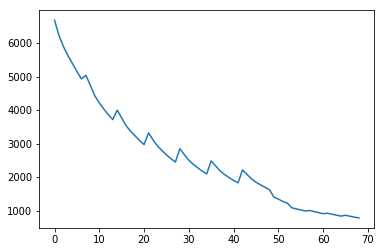

In [20]:
import matplotlib.pyplot as plotter

scores = [6680.62708489, 6222.38988339, 5891.35194913, 5623.3567376, 5391.06404878, 5150.89958683, 4929.80994129, 5036.91692184, 4740.77092124, 4425.69947235, 4212.10038799, 4031.95793356, 3863.09054246, 3715.22125099, 3998.90302957, 3764.1314528, 3527.90901922, 3373.04783744, 3229.03190954, 3091.62013795, 2969.93298554, 3317.31491636, 3111.91975003, 2929.97908759, 2793.51104239, 2663.64300324, 2551.11527568, 2449.04226602, 2847.6889446, 2670.56181004, 2502.76562401, 2381.16653546, 2276.35103775, 2177.83706304, 2095.40357468, 2484.92095349, 2331.4478288, 2183.72012405, 2074.68787017, 1984.09588803, 1901.39996103, 1828.73923004, 2214.18066016, 2078.47351644, 1947.71806889, 1847.8374325, 1769.18061144, 1695.65991897, 1626.51311845, 1403.4163953, 1343.99395874, 1271.93228632, 1224.25056063, 1084.13725677, 1049.98656279, 1020.17405117, 986.68485585, 1002.63188901, 969.833765073, 939.550335766, 908.045501463, 921.967334512, 890.363836172, 863.752971439, 836.423263758, 860.464795338, 831.307077557, 805.189550361, 781.443308413]

plotter.plot(range(len(scores)), scores)
plotter.show()

#### Using data points around error=1000

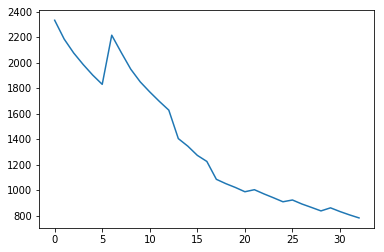

In [22]:
import matplotlib.pyplot as plotter

scores = [2331.4478288, 2183.72012405, 2074.68787017, 1984.09588803,
         1901.39996103, 1828.73923004, 2214.18066016, 2078.47351644, 1947.71806889, 1847.8374325, 1769.18061144, 1695.65991897,
         1626.51311845, 1403.4163953, 1343.99395874, 1271.93228632, 1224.25056063, 1084.13725677, 1049.98656279, 1020.17405117,
         986.68485585, 1002.63188901, 969.833765073, 939.550335766, 908.045501463, 921.967334512, 890.363836172, 863.752971439,
         836.423263758, 860.464795338, 831.307077557, 805.189550361, 781.443308413]

plotter.plot(range(len(scores)), scores)
plotter.show()

#### Data Used for above graph
(locational cluster number, categorical cluster number) K-Means score  
(15, 15) -6680.62708489  
(15, 20) -6222.38988339  
(15, 25) -5891.35194913  
(15, 30) -5623.3567376  
(15, 35) -5391.06404878  
(15, 40) -5150.89958683  
(15, 45) -4929.80994129  
(20, 15) -5036.91692184  
(20, 20) -4740.77092124  
(20, 25) -4425.69947235  
(20, 30) -4212.10038799  
(20, 35) -4031.95793356  
(20, 40) -3863.09054246  
(20, 45) -3715.22125099  
(25, 15) -3998.90302957  
(25, 20) -3764.1314528  
(25, 25) -3527.90901922  
(25, 30) -3373.04783744  
(25, 35) -3229.03190954  
(25, 40) -3091.62013795  
(25, 45) -2969.93298554  
(30, 15) -3317.31491636  
(30, 20) -3111.91975003  
(30, 25) -2929.97908759  
(30, 30) -2793.51104239  
(30, 35) -2663.64300324  
(30, 40) -2551.11527568  
(30, 45) -2449.04226602  
(35, 15) -2847.6889446  
(35, 20) -2670.56181004  
(35, 25) -2502.76562401  
(35, 30) -2381.16653546  
(35, 35) -2276.35103775  
(35, 40) -2177.83706304  
(35, 45) -2095.40357468  
(40, 15) -2484.92095349  
(40, 20) -2331.4478288  
(40, 25) -2183.72012405  
(40, 30) -2074.68787017  
(40, 35) -1984.09588803  
(40, 40) -1901.39996103  
(40, 45) -1828.73923004  
(45, 15) -2214.18066016  
(45, 20) -2078.47351644  
(45, 25) -1947.71806889  
(45, 30) -1847.8374325  
(45, 35) -1769.18061144  
(45, 40) -1695.65991897  
(45, 45) -1626.51311845  
(50, 50) -1403.4163953  
(50, 55) -1343.99395874  
(55, 50) -1271.93228632  
(55, 55) -1224.25056063  
(60, 60) -1084.13725677  
(60, 65) -1049.98656279  
(60, 70) -1020.17405117  
(60, 75) -986.68485585  
(65, 60) -1002.63188901  
(65, 65) -969.833765073  
(65, 70) -939.550335766  
(65, 75) -908.045501463  
(70, 60) -921.967334512  
(70, 65) -890.363836172  
(70, 70) -863.752971439  
(70, 75) -836.423263758  
(75, 60) -860.464795338  
(75, 65) -831.307077557  
(75, 70) -805.189550361  
(75, 75) -781.443308413  

#### Experimentation result:

From the above graph, it can be seen that at **(60, 60) -1084.13725677**, the reduction in error of the clusters starts to slow down. Hence, 60 locational clusters and 60 categorical clusters will give good clusters.

## Running the core logic

In [ ]:
locational_clusters = 60
categorical_clusters = 60
number_of_folds = 10
number_of_repeats = 1
cluster_by_position_and_category_cv(locational_clusters, categorical_clusters, number_of_folds, number_of_repeats)